In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import pymatgen as mg
import plot_misc2
from shutil import copyfile

In [2]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'EIS_data')

In [3]:
datadir

'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\EIS_data'

In [6]:
os.listdir(datadir)

['PDAC_COM3_01488',
 'PDAC_COM3_01533',
 'PDAC_COM3_01535',
 'PDAC_COM3_01542',
 'PDAC_COM3_01545']

In [52]:
sample = 'PDAC_COM3_01488'
sampledir = os.path.join(datadir,sample)
os.chdir(sampledir)
df = pd.DataFrame()
for file in glob.glob('*.txt'):
    tdf = pd.read_csv(file,sep='\t',index_col=0)
    df = df.join(tdf,rsuffix='r',how='outer')
    

In [15]:
def get_file_info(file,sample):
#     sampledir = os.path.join(datadir,sample)
#     os.chdir(sampledir)
    infostr = file.replace(sample,'').replace('.txt','').strip('_')
    info = infostr.split('_')
    return info

def get_all_conditions(sample):
    sampledir = os.path.join(datadir,sample)
    os.chdir(sampledir)
    conditions = []
    for file in glob.glob('*.txt'):
        info = get_file_info(file,sample)
        cond = info[-2:]
        conditions.append(cond)
    return np.unique(conditions,axis=0)

def load_condition_files(condition,append_cond=False):
    cond_str = '_'.join(condition) + '.txt'
    df = pd.DataFrame()
    for file in glob.glob('*' + cond_str):
        tdf = pd.read_csv(file,sep='\t',index_col=0)
        df = df.join(tdf,how='outer')
    if append_cond==True:
        df.loc[:,'T_set'] = cond[0]
        df.loc[:,'Atmosphere'] = cond[1]
        #move point to a column and make composite index
        df.loc[:,'Point'] = df.index
        df.index = df.index.astype(str) + '_' + df.T_set + '_' + df.Atmosphere
    return df

def copy_compfiles(sample,srccond,dstcond): #create missing composition files
    #within a sample, composition is same for all conditions. 
    #Copy src conditon composition files
    sampledir = os.path.join(datadir,sample)
    os.chdir(sampledir)
    elements = ['Ba','Co','Fe','Y','Zr']
    for el in elements:
        srcname = '_'.join([sample,el,'at',srccond]) + '.txt'
        dstname = srcname.replace(srccond,dstcond)
        copyfile(srcname,dstname)
        print('Copied {} to {}'.format(srcname,dstname))

def concat_nameswvalues(df,cols=None,roundvals=False):
    tdf = df.copy()
    if cols==None:
        cols = tdf.columns
    if roundvals!=False:
        tdf = tdf.round(roundvals)
    for col in cols:
        tdf[col] = col + tdf[col].astype(str)
    tdf['concat'] = tdf.apply(lambda x: ''.join(x),axis=1)
    return tdf['concat']

def get_formula(df,overwrite=False):
    #list all possible A and B site elements
    Asite = ['Ba']
    Bsite = ['Co','Fe','Y','Zr']

    #get elements actually present
    at_col = df.columns[df.columns.str.contains('_at')]
    el_col = at_col.str.replace('_at','')
    A_col = np.intersect1d(el_col,Asite)
    B_col = np.intersect1d(el_col,Bsite)
    if len(A_col) + len(B_col) < len(el_col):
        raise Exception('Not all elements are captured in A- and B-site lists')

    comp = df.loc[:,at_col]
    coldict = dict(zip(at_col,el_col))
    comp.rename(columns=coldict,inplace=True) #remove _at from column names
    
    #normalize for higher-occupancy site - assume other site is deficient
    sites = pd.DataFrame()
    sites['A_sum'] = comp[A_col].sum(axis=1)
    sites['B_sum'] = comp[B_col].sum(axis=1)
    sites['sitemax'] = sites.max(axis=1)
    sites['sitesum'] = sites['A_sum'] + sites['B_sum']
    badsum = sites[sites['sitesum'].round(5)!=1].index
    if len(badsum)>0:
        raise Exception('Atomic fractions do not sum to 1 for following points: {}'.format(badsum.values))
    normcomp = comp.divide(sites['sitemax'],axis=0)

    #concatenate elements & fractions to get formula string
    normcomp['formula'] = concat_nameswvalues(normcomp,roundvals=5)
    normcomp['formula'] = normcomp['formula'] + 'O3'
    
    if overwrite==False:
        return normcomp['formula']
    elif overwrite==True:
        df['formula'] = normcomp['formula']
        df.drop(columns=at_col,inplace=True)
        
def lin_reg(x,y):
    #y = mx + b
    model, resid = np.polyfit(x,y,deg=1,full=True)[:2]
    R2 = float(1-resid/(y.size*y.var())) #calculate R^2
    m = model[0]
    b = model[1]
    return m, b, R2
        
def fit_by_point(df, x, y):
    cdf = df.copy()
    fit = pd.DataFrame()
    cdf['x'] = x
    cdf['y'] = y
    for point in cdf['Point'].unique():
        tdf = cdf[cdf['Point']==point]
        x = np.array(tdf['x'])
        y = np.array(tdf['y']) 
        m, b, R2 = lin_reg(x,y)
        fit = fit.append(pd.Series([point,m,b,R2], index=['Point','m','b','R2']),
                             ignore_index=True)
    fit.index = fit['Point']
    fit.drop('Point',axis=1,inplace=True)
    return fit

def cum_dist(binstart,binend,binwidth,x):
    bins = np.arange(binstart,binend + binwidth,binwidth)
    h = np.histogram(x,bins=bins,density=True)
    cs = np.cumsum(h[0])*binwidth
    return bins, cs

def hist_compare(binstart,binend,binwidth,x1,x2,label1,label2,figsize=[8,4],xdec=3,ax=None,yval='percent'):
    barwidth = binwidth*0.4
    bins = np.arange(binstart,binend + binwidth,binwidth)
    bar1 = np.histogram(x1,bins=bins,density=True)
    bar2 = np.histogram(x2,bins=bins,density=True)

    if ax==None:
        fig, ax = plt.subplots(figsize=figsize)
        
    if yval=='density':
        h1 = bar1[0]
        h2 = bar2[0]
    elif yval=='percent':
        h1 = bar1[0]*100*binwidth
        h2 = bar2[0]*100*binwidth
    elif yval=='fraction':
        h1 = bar1[0]*binwidth
        h2 = bar2[0]*binwidth
        
    ax.bar(x=bins[:-1],height=h1,width=barwidth,align='edge',label=label1)
    ax.bar(x=bins[:-1]+barwidth,height=h2,width=barwidth,align='edge',label=label2)
    #ax.set_xticklabels([str(x) + '-' + str(x+0.005) for x in bins[:-1]])
    #ax.set_xticklabels(np.arange(0,len(bins[:-1])))
    ax.legend()
    #xticks = ax.get_xticks()
    ax.set_xticks(bins[:-1]+barwidth)
    #ax.set_xticklabels(['('+str(x) + ',' + str(x+binwidth) + ')' for x in bins[:-1]])
    ax.set_xticklabels(['({:>{dec}f},{:>{dec}f})'.format(x,x+binwidth,dec=xdec/10) for x in bins[:-1]])
    
    


In [748]:
missing_comp_samples = ['PDAC_COM3_01533','PDAC_COM3_01535','PDAC_COM3_01542','PDAC_COM3_01545']
for sample in missing_comp_samples:
    print(sample + '\n---------------------')
    copy_compfiles(sample,srccond='300C_dry',dstcond='300C_wet')

PDAC_COM3_01533
---------------------
Copied PDAC_COM3_01533_Ba_at_300C_dry.txt to PDAC_COM3_01533_Ba_at_300C_wet.txt
Copied PDAC_COM3_01533_Co_at_300C_dry.txt to PDAC_COM3_01533_Co_at_300C_wet.txt
Copied PDAC_COM3_01533_Fe_at_300C_dry.txt to PDAC_COM3_01533_Fe_at_300C_wet.txt
Copied PDAC_COM3_01533_Y_at_300C_dry.txt to PDAC_COM3_01533_Y_at_300C_wet.txt
Copied PDAC_COM3_01533_Zr_at_300C_dry.txt to PDAC_COM3_01533_Zr_at_300C_wet.txt
PDAC_COM3_01535
---------------------
Copied PDAC_COM3_01535_Ba_at_300C_dry.txt to PDAC_COM3_01535_Ba_at_300C_wet.txt
Copied PDAC_COM3_01535_Co_at_300C_dry.txt to PDAC_COM3_01535_Co_at_300C_wet.txt
Copied PDAC_COM3_01535_Fe_at_300C_dry.txt to PDAC_COM3_01535_Fe_at_300C_wet.txt
Copied PDAC_COM3_01535_Y_at_300C_dry.txt to PDAC_COM3_01535_Y_at_300C_wet.txt
Copied PDAC_COM3_01535_Zr_at_300C_dry.txt to PDAC_COM3_01535_Zr_at_300C_wet.txt
PDAC_COM3_01542
---------------------
Copied PDAC_COM3_01542_Ba_at_300C_dry.txt to PDAC_COM3_01542_Ba_at_300C_wet.txt
Copied PDA

In [678]:
sample = 'PDAC_COM3_01488'

conditions = get_all_conditions(sample)

T_order = {'300C':1,'400C':2,'500C':3,'401C':4,'301C':5}
T_act = {'300C':265,'400C':351,'500C':437,'401C':351,'301C':265}

df = pd.DataFrame()
for cond in conditions:
    tdf = load_condition_files(cond,append_cond=True)
    get_formula(tdf,overwrite=True)
    df = df.append(tdf)

df['T_order'] = df['T_set'].map(T_order)
df['T_act'] = df['T_set'].map(T_act)
df['T(K)'] = df['T_act'] + 273
df.sort_values(by=['Point','Atmosphere','T_order'],axis=0,inplace=True)

Text(0.5,0,'1/T')

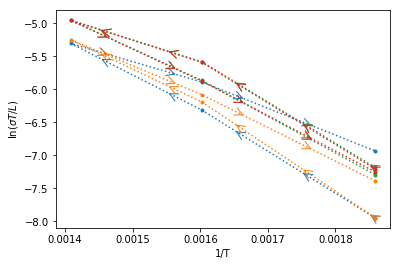

In [482]:
df.sort_values(by=['Point','Atmosphere','T_order'],axis=0,inplace=True)

for point in range(1,5):#df['Point'].unique():
    pdf = df.loc[df['Point'] == point,:]
    pdfd = pdf[pdf['Atmosphere']=='dry']
    p = plt.plot(1/pdfd.loc[:,'T(K)'],np.log(pdfd.loc[:,'T(K)']/pdfd.loc[:,'ASR']), ls=':',marker='.',label=point)
    plot_misc2.add_arrows(p,xint=0.0001,size=20)
plt.ylabel(r'ln($\sigma T/L)$')
plt.xlabel('1/T')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000202760C8FD0>]],
      dtype=object)

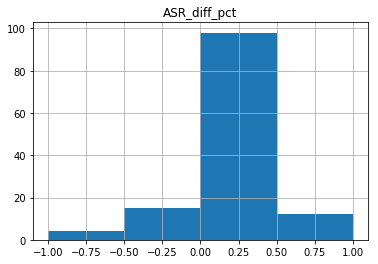

In [477]:
df300 = df.loc[(df['T_set']=='300C') & (df['Atmosphere']=='dry'),:]
df301 = df.loc[(df['T_set']=='301C') & (df['Atmosphere']=='dry'),:]
df300.index = df300['Point']
df301.index = df301['Point']
dfcompare = pd.DataFrame()#df300.join(df301,rsuffix='1')
dfcompare['ASR_diff'] = df301['ASR'] - df300['ASR']
dfcompare['ASR_diff_pct'] = dfcompare['ASR_diff']/df300['ASR']
dfcompare['ASR_diff_sign'] = np.sign(dfcompare['ASR_diff'])
dfcompare.hist('ASR_diff_pct',bins=[-1,-0.5,0,0.5,1])

Text(0.5,0,'1/T')

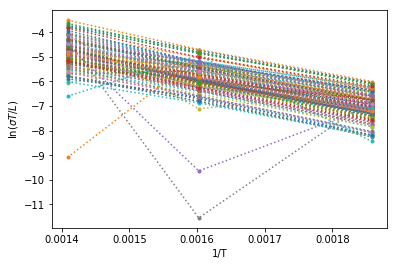

In [657]:
df
tdf = df.loc[(df['Atmosphere']=='dry') & (df['T_order']>=3),:]
tdf

for point in range(1,132):
    ttdf = tdf[tdf['Point']==point]
    p = plt.plot(1/ttdf['T(K)'],np.log(ttdf['T(K)']/ttdf['ASR']), ls=':',marker='.',label=point)
    #plot_misc2.add_arrows(p,xint=0.0001,size=20)
plt.ylabel(r'ln($\sigma T/L)$')
plt.xlabel('1/T')

In [675]:
T_fit1 = fit_by_point(tdf, x=1/tdf['T(K)'], y=np.log(1/tdf['ASR']))
T_fit2 = fit_by_point(tdf, x=1/tdf['T(K)'], y=np.log(tdf['T(K)']/tdf['ASR']))
T_fit1.join(T_fit2,lsuffix='_1',rsuffix='_2')

,R2_1,b_1,m_1,R2_2,b_2,m_2
Point,,,,,,
1.0,0.988761,-7.569826,-3020.321378,0.993334,-0.143171,-3634.457548
2.0,0.996381,-5.940321,-4145.172896,0.997759,1.486333,-4759.309066
3.0,0.996481,-5.021989,-4587.307380,0.997726,2.404666,-5201.443551
4.0,0.998196,-5.163062,-4493.409562,0.998935,2.263593,-5107.545733
5.0,0.999090,-5.671744,-4220.258818,0.999545,1.754911,-4834.394989
6.0,0.999874,-6.004597,-4007.150519,0.999775,1.422057,-4621.286689
7.0,0.999958,-6.437990,-3818.506879,1.000000,0.988665,-4432.643049
8.0,0.998094,-6.928336,-3482.460666,0.999026,0.498319,-4096.596836
9.0,0.990791,-7.111639,-3398.724417,0.994317,0.315016,-4012.860588


In [538]:
t_fit = pd.DataFrame()
for point in range(1,133):
    ttdf = tdf[tdf['Point']==point]
    x = np.array(1/ttdf['T(K)'])
    y1 = np.array(np.log(1/ttdf['ASR'])) #sigma/L
    y2 = np.array(np.log(ttdf['T(K)']/ttdf['ASR'])) #sigma*T/L
    model1, resid1 = np.polyfit(x,y1,deg=1,full=True)[:2]
    R2_1 = float(1-resid1/(y1.size*y1.var()))
    model2, resid2 = np.polyfit(x,y2,deg=1,full=True)[:2]
    R2_2 = float(1-resid2/(y2.size*y2.var()))
    t_fit = t_fit.append(pd.Series([point,model1[0],model1[1],R2_1,model2[0],model2[1],R2_2],
                                   index=['Point','m1','b1','R2_1','m2','b2','R2_2'])
                         ,ignore_index=True)
t_fit

,Point,R2_1,R2_2,b1,b2,m1,m2
0,1.0,0.988761,0.993334,-7.569826,-0.143171,-3020.321378,-3634.457548
1,2.0,0.996381,0.997759,-5.940321,1.486333,-4145.172896,-4759.309066
2,3.0,0.996481,0.997726,-5.021989,2.404666,-4587.307380,-5201.443551
3,4.0,0.998196,0.998935,-5.163062,2.263593,-4493.409562,-5107.545733
4,5.0,0.999090,0.999545,-5.671744,1.754911,-4220.258818,-4834.394989
5,6.0,0.999874,0.999775,-6.004597,1.422057,-4007.150519,-4621.286689
6,7.0,0.999958,1.000000,-6.437990,0.988665,-3818.506879,-4432.643049
7,8.0,0.998094,0.999026,-6.928336,0.498319,-3482.460666,-4096.596836
8,9.0,0.990791,0.994317,-7.111639,0.315016,-3398.724417,-4012.860588
9,10.0,0.999168,0.999665,-7.304475,0.122180,-3364.188568,-3978.324738


In [539]:
t_fit.R2_1.mean(), t_fit.R2_2.mean()

(0.9471625840632201, 0.951546960570086)

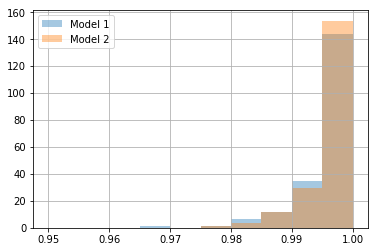

In [564]:
t_fit.R2_1.hist(bins=np.arange(0.95,1.001,0.005),label='Model 1',alpha=0.4,density=True)
t_fit.R2_2.hist(bins=np.arange(0.95,1.001,0.005),label='Model 2',alpha=0.4,density=True)
plt.legend()

[Text(0,0,'(0.980,0.985)'),
 Text(0,0,'(0.985,0.990)'),
 Text(0,0,'(0.990,0.995)'),
 Text(0,0,'(0.995,1.000)')]

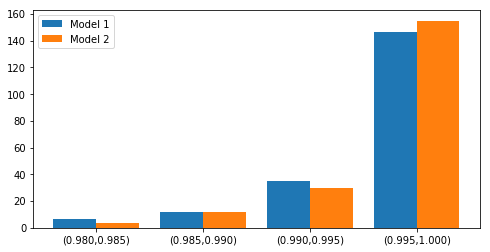

In [681]:
binwidth = 0.005
barwidth = binwidth*0.4
bins=np.arange(0.98,1 + binwidth,binwidth)
bar1 = np.histogram(t_fit.R2_1,bins=bins,density=True)
bar2 = np.histogram(t_fit.R2_2,bins=bins,density=True)

fig, ax = plt.subplots(figsize=[8,4])
ax.bar(x=bins[:-1],height=bar1[0],width=barwidth,align='edge',label='Model 1')
ax.bar(x=bins[:-1]+barwidth,height=bar2[0],width=barwidth,align='edge',label='Model 2')
#ax.set_xticklabels([str(x) + '-' + str(x+0.005) for x in bins[:-1]])
#ax.set_xticklabels(np.arange(0,len(bins[:-1])))
ax.legend()
#xticks = ax.get_xticks()
ax.set_xticks(bins[:-1]+barwidth)
#ax.set_xticklabels(['('+str(x) + ',' + str(x+binwidth) + ')' for x in bins[:-1]])
ax.set_xticklabels(['({:.3f},{:.3f})'.format(x,x+binwidth) for x in bins[:-1]])

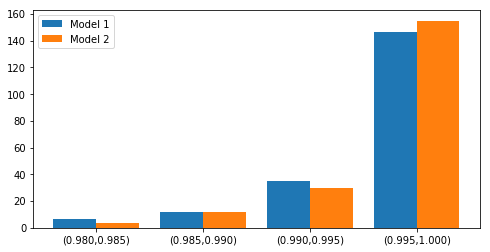

In [761]:
binstart = 0.98
binend=1
binwidth = 0.005
x1 = t_fit.R2_1
x2 = t_fit.R2_2
label1='Model 1'
label2='Model 2'
hist_compare(binstart,binend,binwidth,x1,x2,label1,label2)

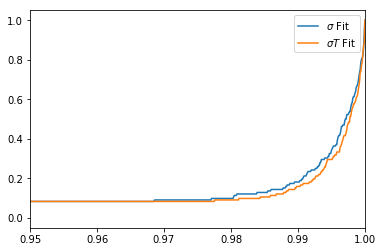

In [683]:
binwidth = 0.0001
binstart = 0
binend = 1
bins, cs1 = cum_dist(binstart,binend,binwidth,t_fit.R2_1)
bins, cs2 = cum_dist(binstart,binend,binwidth,t_fit.R2_2)
plt.plot(bins[1:],cs1,label='$\sigma$ Fit')
plt.plot(bins[1:],cs2,label = '$\sigma T$ Fit')
plt.xlim([0.95,1])
plt.legend()

In [5]:
k_B = 8.61733e-5 #Boltzmann constant in eV/K

PDAC_COM3_01488
PDAC_COM3_01533
PDAC_COM3_01535


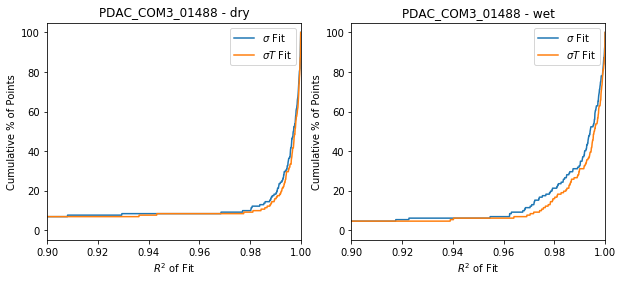

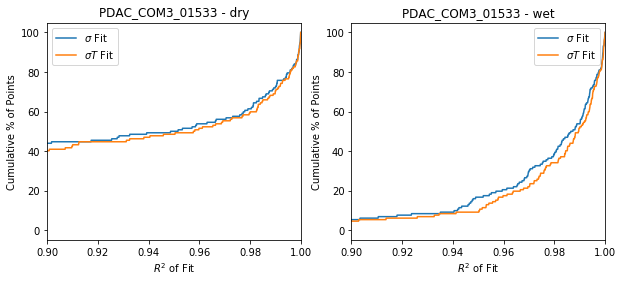

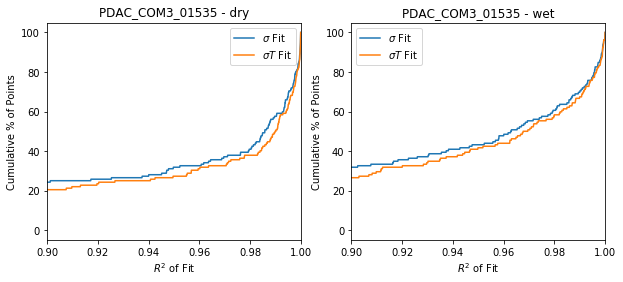

In [6]:
#get distribution of activation energies
k_B = 8.61733e-5

samples = next(os.walk(datadir))[1]
samples = np.delete(samples,[3,4]) #can't fit 01542 or 01545 yet
for sample in samples:
    #sample = 'PDAC_COM3_01488'
    print(sample)

    conditions = get_all_conditions(sample)
    #don't load 300C_wet for now - missing composition data
#     delidx = np.where((conditions[:,0]=='300C') & (conditions[:,1]=='wet'))
#     conditions = np.delete(conditions,delidx,axis=0)

    T_order = {'300C':1,'400C':2,'500C':3,'401C':4,'301C':5}
    T_act = {'300C':265,'400C':351,'500C':437,'401C':351,'301C':265}

    df = pd.DataFrame()
    for cond in conditions:
        tdf = load_condition_files(cond,append_cond=True)
        get_formula(tdf,overwrite=True)
        df = df.append(tdf)

    df['T_order'] = df['T_set'].map(T_order)
    df['T_act'] = df['T_set'].map(T_act)
    df['T(K)'] = df['T_act'] + 273
    df.sort_values(by=['Point','Atmosphere','T_order'],axis=0,inplace=True)

    fig, axes = plt.subplots(1,2,figsize=(10,4))
    for i, atm in enumerate(['dry','wet']):
        atm_df = df.loc[(df['Atmosphere']==atm) & (df['T_order']>=3),:]
        T_fit1 = fit_by_point(atm_df, x=1/atm_df['T(K)'], y=np.log(1/atm_df['ASR']))
        T_fit2 = fit_by_point(atm_df, x=1/atm_df['T(K)'], y=np.log(atm_df['T(K)']/atm_df['ASR']))

        ax = axes[i]
        binwidth = 0.0001
        binstart = 0
        binend = 1
        bins, cs1 = cum_dist(binstart,binend,binwidth,T_fit1.R2)
        bins, cs2 = cum_dist(binstart,binend,binwidth,T_fit2.R2)
        ax.plot(bins[1:],100*cs1,label='$\sigma$ Fit')
        ax.plot(bins[1:],100*cs2,label = '$\sigma T$ Fit')
        ax.set_xlim([0.9,1])
        ax.legend()
        ax.set_title('{} - {}'.format(sample,atm))
        ax.set_xlabel('$R^2$ of Fit')
        ax.set_ylabel('Cumulative % of Points')

PDAC_COM3_01488
PDAC_COM3_01533
PDAC_COM3_01535


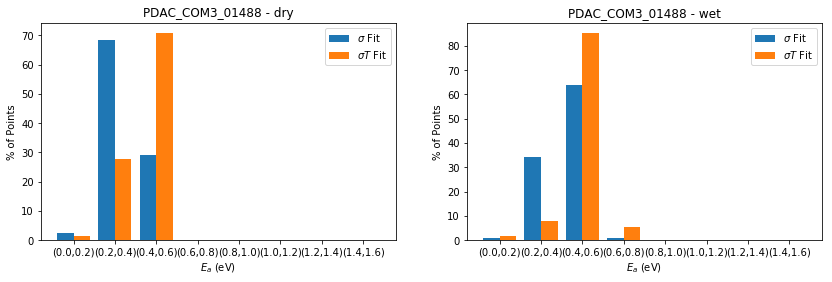

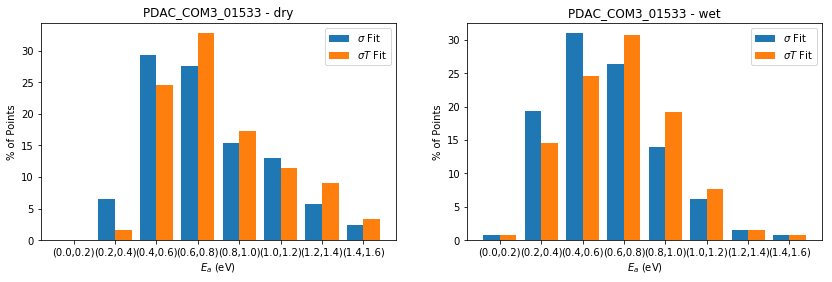

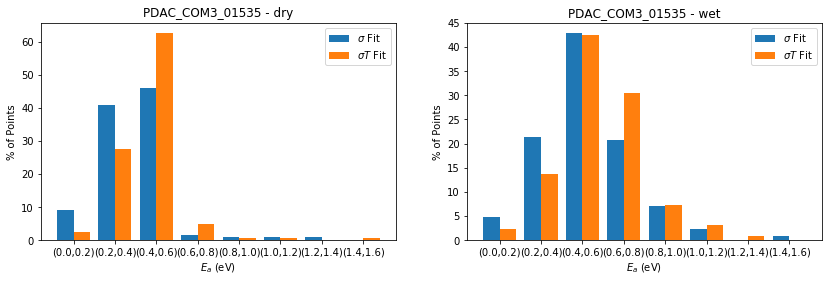

In [18]:
samples = next(os.walk(datadir))[1]
samples = np.delete(samples,[3,4]) #can't fit 01542 or 01545 yet
for sample in samples:
    #sample = 'PDAC_COM3_01488'
    print(sample)

    conditions = get_all_conditions(sample)
    #don't load 300C_wet for now - missing composition data
#     delidx = np.where((conditions[:,0]=='300C') & (conditions[:,1]=='wet'))
#     conditions = np.delete(conditions,delidx,axis=0)

    T_order = {'300C':1,'400C':2,'500C':3,'401C':4,'301C':5}
    T_act = {'300C':265,'400C':351,'500C':437,'401C':351,'301C':265}

    df = pd.DataFrame()
    for cond in conditions:
        tdf = load_condition_files(cond,append_cond=True)
        get_formula(tdf,overwrite=True)
        df = df.append(tdf)

    df['T_order'] = df['T_set'].map(T_order)
    df['T_act'] = df['T_set'].map(T_act)
    df['T(K)'] = df['T_act'] + 273
    df.sort_values(by=['Point','Atmosphere','T_order'],axis=0,inplace=True)

    fig, axes = plt.subplots(1,2,figsize=(14,4))
    for i, atm in enumerate(['dry','wet']):
        atm_df = df.loc[(df['Atmosphere']==atm) & (df['T_order']>=3),:]
        T_fit1 = fit_by_point(atm_df, x=1/atm_df['T(K)'], y=np.log(1/atm_df['ASR']))
        T_fit2 = fit_by_point(atm_df, x=1/atm_df['T(K)'], y=np.log(atm_df['T(K)']/atm_df['ASR']))
        
        ax = axes[i]
        x1 = T_fit1.m*-k_B
        x2 = T_fit2.m*-k_B
#         binstart = np.maximum(0,np.minimum(x1.min(),x2.min())) #don't go below zero
#         binend = np.maximum(x1.max(),x2.max())
#         binwidth = (binend-binstart)/5
        binstart = 0
        binend = 1.6
        binwidth = 1.6/8
        
        label1='$\sigma$ Fit'
        label2='$\sigma T$ Fit'
        hist_compare(binstart,binend,binwidth,x1,x2,label1,label2,ax=ax,xdec=1,yval='percent')
        ax.legend()
        ax.set_title('{} - {}'.format(sample,atm))
        ax.set_xlabel('$E_a$ (eV)')
        ax.set_ylabel('% of Points')
    


In [775]:
np.minimum(x1.min(),x2.min())

-0.5416876894718866

In [733]:
cdf = atm_df.copy()
x=1/atm_df['T(K)']
y=np.log(1/atm_df['ASR'])
fit = pd.DataFrame()
cdf['x'] = x
cdf['y'] = y
cdf[cdf['Point']==30]
# for point in cdf['Point'].unique():
#     print(point)
#     tdf = cdf[cdf['Point']==point]
#     x = np.array(tdf['x'])
#     y = np.array(tdf['y']) 
#     m, b, R2 = lin_reg(x,y)
#     fit = fit.append(pd.Series([point,m,b,R2], index=['Point','m','b','R2']),
#                          ignore_index=True)
# fit.index = fit['Point']
# fit.drop('Point',axis=1,inplace=True)

,ASR,Rp,T_set,Atmosphere,Point,formula,T_order,T_act,T(K),x,y
Atmosphere,,,,,,,,,,,
30_500C_dry,293330530.0,9.337008e+09,500C,dry,30,Ba0.91916Co0.01324Fe0.46818Y0.0Zr0.51858O3,3,437,710,0.001408,-19.496811
30_401C_dry,651251840.0,2.073001e+10,401C,dry,30,Ba0.91916Co0.01324Fe0.46818Y0.0Zr0.51858O3,4,351,624,0.001603,-20.294407
30_301C_dry,NaN,NaN,301C,dry,30,Ba0.91916Co0.01324Fe0.46818Y0.0Zr0.51858O3,5,265,538,0.001859,NaN


In [712]:
sample = 'PDAC_COM3_01533'

conditions = get_all_conditions(sample)

T_order = {'300C':1,'400C':2,'500C':3,'401C':4,'301C':5}
T_act = {'300C':265,'400C':351,'500C':437,'401C':351,'301C':265}

df = pd.DataFrame()
for cond in conditions:
    tdf = load_condition_files(cond,append_cond=True)
    get_formula(tdf,overwrite=False)
    df = df.append(tdf)
df[df['Atmosphere']=='wet']

AttributeError: Can only use .str accessor with string values (i.e. inferred_type is 'string', 'unicode' or 'mixed')